In [2]:
# This is just a scratch cell for pip install commands
%pip install scikit-image

     ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.5 MB 2.4 MB/s eta 0:00:10
      --------------------------------------- 0.4/24.5 MB 4.3 MB/s eta 0:00:06
     - -------------------------------------- 0.7/24.5 MB 4.6 MB/s eta 0:00:06
     - -------------------------------------- 0.9/24.5 MB 4.8 MB/s eta 0:00:05
     - -------------------------------------- 1.1/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.3/24.5 MB 4.7 MB/s eta 0:00:05
     -- ------------------------------------- 1.6/24.5 MB 5.0 MB/s eta 0:00:05
     --- ------------------------------------ 1.9/24.5 MB 5.1 MB/s eta 0:00:05
     --- ------------------------------------ 2.4/24.5 MB 5.6 MB/s eta 0:00:04
     ---- ----------------------------------- 2.7/24.5 MB 5.8 MB/s eta 0:00:04
     ----- ---------------------------------- 3.2/24.5 MB 6.3 MB/s eta 0:00:04
     ------ --------------------------------- 3.7/24.5 MB 6

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from textwrap import wrap
from skimage import exposure, color

import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

In [2]:
# Loading labels.csv

label_key = pd.read_csv('labels.csv')

In [3]:
print(label_key)

    ClassId                          Name
0         0           Speed limit (5km/h)
1         1          Speed limit (15km/h)
2         2          Speed limit (30km/h)
3         3          Speed limit (40km/h)
4         4          Speed limit (50km/h)
5         5          Speed limit (60km/h)
6         6          Speed limit (70km/h)
7         7          speed limit (80km/h)
8         8      Dont Go straight or left
9         9     Dont Go straight or Right
10       10              Dont Go straight
11       11                  Dont Go Left
12       12         Dont Go Left or Right
13       13                 Dont Go Right
14       14       Dont overtake from Left
15       15                      No Uturn
16       16                        No Car
17       17                       No horn
18       18          Speed limit (40km/h)
19       19          Speed limit (50km/h)
20       20          Go straight or right
21       21                   Go straight
22       22                       

In [4]:
# Defining an ImageDatGenerator 
# This is used to homogenize image data for conversion to array
# This can also be used to augment data
# Currently, only used to normalize values between 0.0 and 1.0

datagen = ImageDataGenerator(
    rescale=1.0/255.0
)


In [5]:
# Defining indices of unknowns

unknowns = [40,41,42,45,49,52,56,57]

In [44]:
# Loading training images and label data
# Using flow_from_directory function of the above ImageDataGenerator object
# Currently working on batches of 64, with no shuffling.
# Fixing output image size to 256x256

train_path = 'traffic_Data/DATA/'
trn_img_arr_list = []
trn_label_arr_list = []

img_itr = datagen.flow_from_directory(
    directory=train_path,
    target_size=(128,128),
    shuffle=False,
    batch_size = 1
)

# Going through the dictionary iterable returned by the above function

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  if not np.any(label[:,unknowns] == 1):
    trn_img_arr_list.append(img)
    trn_label_arr_list.append(label)
  

# Converting the lists to numpy arrays
# And printing their shape to check dimensions

trn_img_arr = np.concatenate(trn_img_arr_list, axis=0)
trn_label_arr = np.concatenate(trn_label_arr_list, axis=0)
print("Training Image Array dimensions: ",trn_img_arr.shape)
print("Training Labels Array dimensions: ",trn_label_arr.shape)

# From the output of the above print statements, we see:
# Training image array is 4170x256x256x3
# Label array is 4170x58
# Thus, there are 4170 training images, each of size 256x256, and 3 colour channels
# The labels are also one-hot encoded

# Note: ImageDataGenerator.flow_from_directory expects image data to be organized as such:
# Images are to be organized into subfolders based on label
# The name of each subfolder is taken as the label name
# Fortunately, our data is already structured as required

Found 4170 images belonging to 58 classes.
Training Image Array dimensions:  (3800, 128, 128, 3)
Training Labels Array dimensions:  (3800, 58)


In [45]:
# Loading test images and label data
# The process is identical to the previous cell

test_path = 'traffic_Data/TEST_STRUCTURED'
tst_img_arr_list = []
tst_label_arr_list = []


img_itr = datagen.flow_from_directory(
    directory=test_path,
    target_size=(128,128),
    shuffle=False,
    batch_size = 1
)

for i in  range(len(img_itr)):
  img, label = img_itr[i]
  if not np.any(label[:,unknowns] == 1):
    tst_img_arr_list.append(img)
    tst_label_arr_list.append(label)

tst_img_arr = np.concatenate(tst_img_arr_list, axis=0)
tst_label_arr = np.concatenate(tst_label_arr_list, axis=0)
print("Training Image Array dimensions: ",tst_img_arr.shape)
print("Training Labels Array dimensions: ",tst_label_arr.shape)

# According to the print statements, we see:
# Test Image Array dimensions: 1994x256x256x3
# Test Labels Array dimensions: 1994x58
# Thus, there are 1994 test images, each of size 256x256, with 3 colour channels
# The labels are also one-hot encoded

# test set missing class 9, 18, 19, 33

Found 1998 images belonging to 58 classes.
(1865, 128, 128, 3)
(1865, 58)


Visualizing Data

In [46]:
# Defining a function to create a bar plot for class distribution
# Called twice, once for training set and once for test set

def class_balance_plot(x, y, bar_width=0.5, title="Title"):
    plt.figure(figsize=(10,10))
    plt.bar(x, y, width=bar_width)
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, ha='center')
    plt.title(title)
    plt.tight_layout()

    return plt.gca()

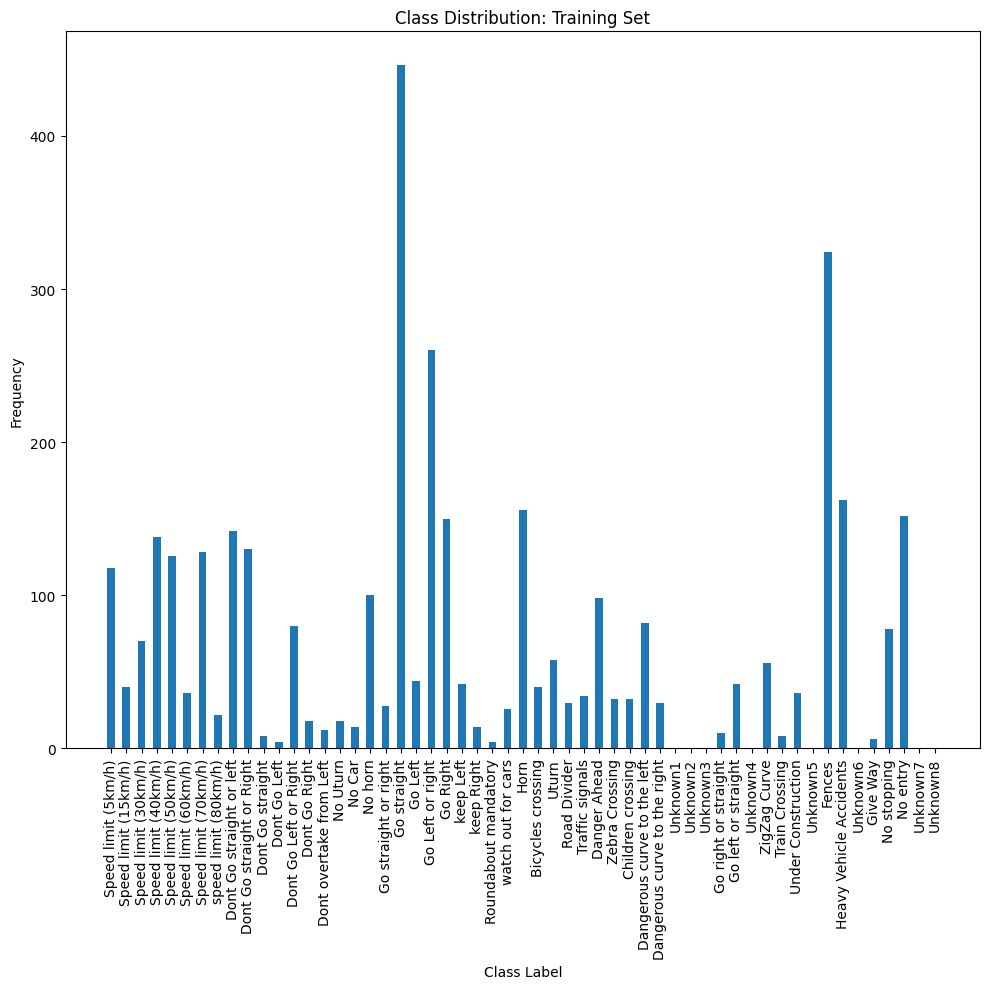

In [47]:
# Visualising class balance in training set

class_names = label_key['Name'].values
trn_class_count = np.sum(trn_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, trn_class_count, title="Class Distribution: Training Set")
plt.show()

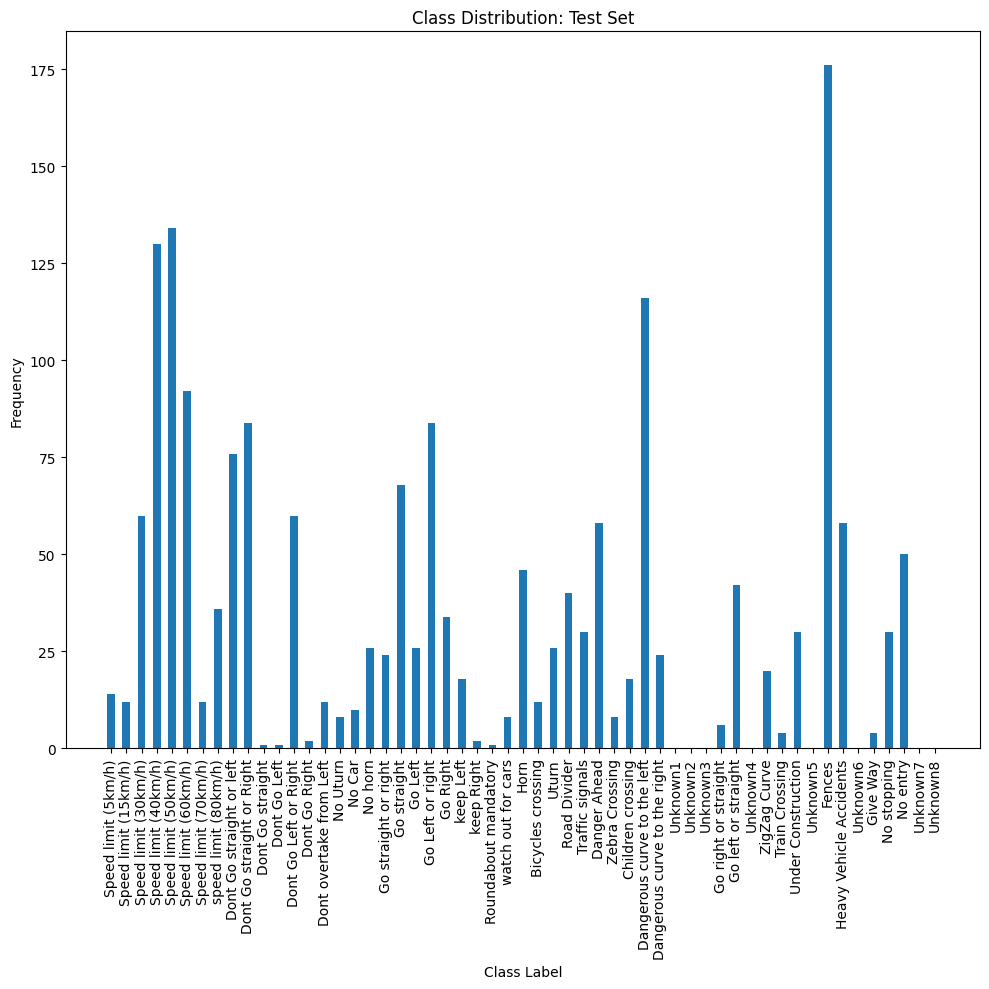

In [48]:
# Visualizing class balance in test set

class_names = label_key['Name'].values
tst_class_count = np.sum(tst_label_arr, axis=0)
trn_chart = class_balance_plot(class_names, tst_class_count, title="Class Distribution: Test Set")
plt.show()

Addressing Imbalance in Training Set

In [65]:
# Removing Unknown classes
# from label arrays
# NOT needed to be removed from image arrays
# since unknown images weren't added to the accumulator lists in the first place
array_2d = np.random.random((3800, 58))

# Create a boolean mask for columns to keep
mask = np.ones(array_2d.shape[1], dtype=bool)
mask[unknowns] = False

# Apply the mask to remove columns
trn_label_arr_masked = trn_label_arr[:, mask]
tst_label_arr_masked = tst_label_arr[:,mask]

print("Original Train label array shape:", trn_label_arr.shape)
print("Shape after removing unknown columns:", trn_label_arr_masked.shape)

print("Original Test label array shape:", tst_label_arr.shape)
print("Shape after removing unknown columns:", tst_label_arr_masked.shape)

# Removing corresponding elements from class_count arrays
trn_class_count_masked = trn_class_count[mask]
tst_class_count_masked = tst_class_count[mask]

# Removing corresponding class names
class_names_masked = class_names[mask]

Original Train label array shape: (3800, 58)
Shape after removing unknown columns: (3800, 50)
Original Test label array shape: (1865, 58)
Shape after removing unknown columns: (1865, 50)


In [66]:
# Defining thresholds for demarcating minority, average, and majority classes
# based on mean, not percentiles
# Adjust as needed

min_thres = np.mean(trn_class_count_masked) 
maj_thres = np.mean(trn_class_count_masked) 

# Getting indices of the minority and majority classes
# based on above-defined thresholds

minority_classes_idx = np.squeeze(np.array(np.where(trn_class_count_masked < min_thres)))
print("Indexes of minority classes:",minority_classes_idx)
majority_classes_idx = np.squeeze(np.array(np.where(trn_class_count_masked >= maj_thres)))
print("Indexes of majority classes",majority_classes_idx)



Indexes of minority classes: [ 1  2  5  7 10 11 13 14 15 16 18 20 22 25 26 27 28 30 31 32 33 35 36 37
 39 40 41 42 43 44 47]
Indexes of majority classes [ 0  3  4  6  8  9 12 17 19 21 23 24 29 34 38 45 46 48 49]


In [67]:
# Trying Under/Oversampling:
# Oversample small classes and Undersample large classes

# Defining accumulator lists
upsample_img = []
upsample_label = []
downsample_img = []
downsample_label = []


for idx in minority_classes_idx:
    min_img_rows = trn_label_arr_masked[:,idx]
    min_img_arr = trn_img_arr[min_img_rows == 1, :, :,:]
    
    upsample_batch = resample(min_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count_masked)))
    
    label_temp = np.zeros((len(upsample_batch), len(trn_class_count_masked)))
    label_temp[:,idx] = 1

    upsample_img.append(upsample_batch)
    upsample_label.append(label_temp)

upsample_img = np.concatenate(upsample_img, axis=0)
print("Shape of upsampled image array:",upsample_img.shape)
upsample_label = np.concatenate(upsample_label, axis=0)
print("Shape of upsampled label array:",upsample_label.shape)

for idx in majority_classes_idx:
    maj_img_rows = trn_label_arr_masked[:,idx]
    maj_img_arr = trn_img_arr[maj_img_rows == 1, :, :,:]
    
    downsample_batch = resample(maj_img_arr,
                            replace=True,
                            n_samples=int(np.mean(trn_class_count_masked)))
    
    label_temp = np.zeros((len(downsample_batch), len(trn_class_count_masked)))
    label_temp[:,idx] = 1

    downsample_img.append(downsample_batch)
    downsample_label.append(label_temp)

downsample_img = np.concatenate(downsample_img, axis=0)
print("Shape of downsampled image array:",downsample_img.shape)
downsample_label = np.concatenate(downsample_label, axis=0)
print("Shape of downsampled label array:",downsample_label.shape)

    


Shape of upsampled image array: (2356, 128, 128, 3)
Shape of upsampled label array: (2356, 50)
Shape of downsampled image array: (1444, 128, 128, 3)
Shape of downsampled label array: (1444, 50)


Shape of equalized image array:  (3800, 128, 128, 3)
Shape of equalized label array:  (3800, 50)


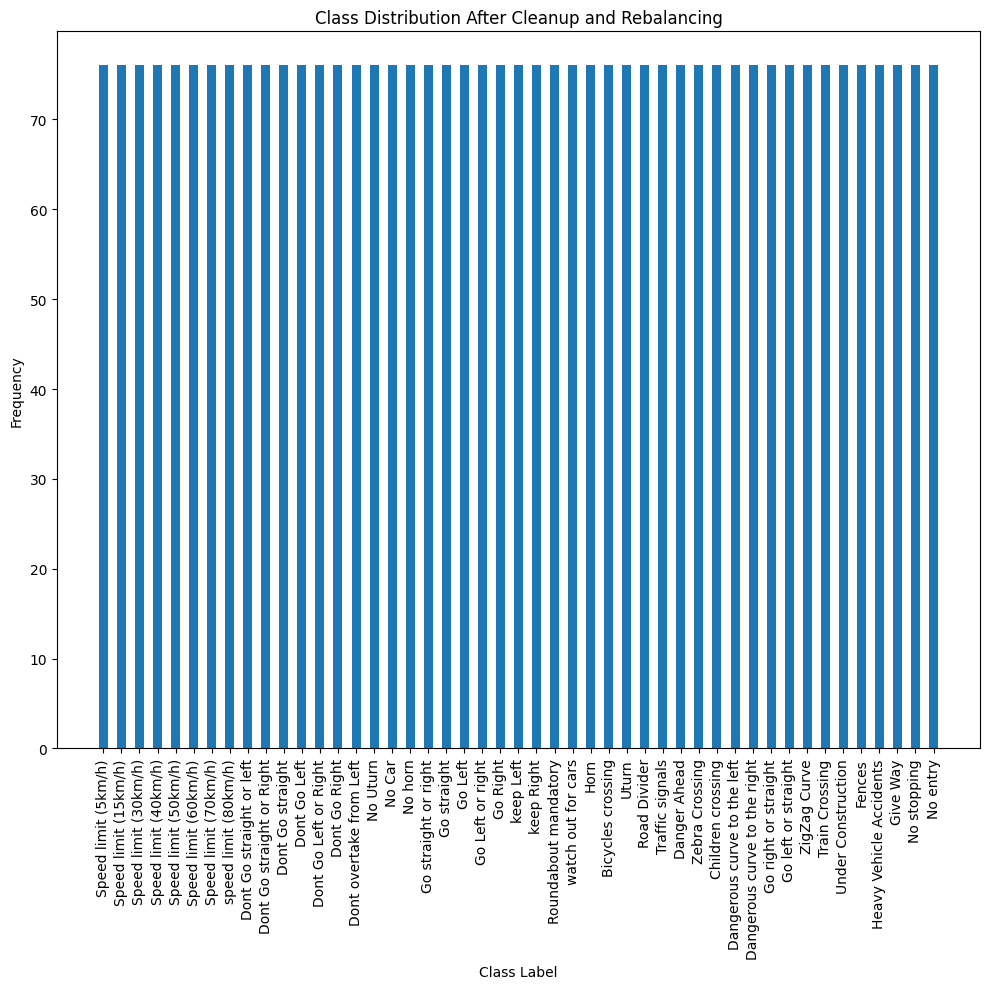

In [71]:
# Joining the upsampled and downsampled sets
# Getting the class distribution of equalized classes
# Checking the shape of the new balanced set
trn_img_arr_eql = np.concatenate((upsample_img, downsample_img), axis=0)
trn_label_arr_eql = np.concatenate((upsample_label, downsample_label), axis=0)

class_count_eql = trn_label_arr_eql.sum(axis=0)
print("Shape of equalized image array: ",trn_img_arr_eql.shape)
print("Shape of equalized label array: ",trn_label_arr_eql.shape)

equalized_distribution = class_balance_plot(class_names_masked, class_count_eql, title="Class Distribution After Cleanup and Rebalancing")
plt.show()

As we can see from the above graph, the classes are cleaned up and balanced

In [73]:
# Splitting validation set off from training set

trn_img_arr, val_img_arr, trn_label_arr_masked, val_label_arr = train_test_split(trn_img_arr, trn_label_arr_masked, test_size=0.2, random_state=42)
print("Shape of training image array: ", trn_img_arr.shape)
print("Shape of training label array: ", trn_label_arr_masked.shape)
print("Shape of validation image array: ", val_img_arr.shape)
print("Shape of validation label array: ", val_label_arr.shape)

Shape of training image array:  (3040, 128, 128, 3)
Shape of training label array:  (3040, 50)
Shape of validation image array:  (760, 128, 128, 3)
Shape of validation label array:  (760, 50)
